In [1]:
###############################################
# 1. LOAD DATA
###############################################

df <- read.csv("data_gempa.csv")

# Pilih fitur numerik yang akan digunakan
df <- df[, c("Latitude", "Longitude", "Depth.km", "Magnitude")]
colnames(df) <- c("lat", "lon", "depth", "mag")

# Hapus missing value jika ada
df <- na.omit(df)

head(df)

,lat,lon,depth,mag
,<dbl>,<dbl>,<dbl>,<dbl>
1,-1.5516,99.4165,28.42,4.6
2,-4.9258,102.7843,52.78,4.6
3,-5.1320,102.3652,34.91,4.8
4,-3.7715,101.1315,35.00,4.0
5,-1.9120,99.8976,10.00,5.2
6,-2.9219,101.0474,62.54,5.0


In [2]:
###############################################
# 2. PREPROCESSING: NORMALISASI / SCALING
###############################################

scale_features <- function(df, cols) {
  mu <- sapply(df[, cols], mean)
  sigma <- sapply(df[, cols], sd)

  df_scaled <- as.data.frame(scale(df[, cols]))

  list(
    scaled = df_scaled,
    mu = mu,
    sd = sigma
  )
}

scaled_data <- scale_features(df, c("lat", "lon", "depth"))
df_scaled <- cbind(scaled_data$scaled, mag = df$mag)

In [3]:
###############################################
# 3. SPLIT TRAINING – TESTING
###############################################

set.seed(123)
n <- nrow(df)

train_idx <- sample(1:n, size = 0.8 * n)
test_idx <- setdiff(1:n, train_idx)

train <- df_scaled[train_idx, ]
test  <- df_scaled[test_idx, ]

In [4]:
###############################################
# 4. INISIALISASI MODEL REGRESI LINEAR
###############################################

X_train <- as.matrix(cbind(1, train[, c("lat", "lon", "depth")])) # tambah intercept
y_train <- as.matrix(train$mag)

X_test <- as.matrix(cbind(1, test[, c("lat", "lon", "depth")]))
y_test <- as.matrix(test$mag)

theta <- matrix(runif(4), nrow = 4)  # inisialisasi bobot acak

In [16]:
###############################################
# 5. GRADIENT DESCENT ITERATIF
###############################################

gradient_descent_tracking <- function(X, y, lr = 0.01, it = 500, tol = 1e-6) {
  m <- nrow(X)
  n <- ncol(X)

  beta <- matrix(0, n, 1)

  beta_history <- list()
  delta_beta_history <- c()
  loss_history <- c()
  delta_loss_history <- c()

  prev_loss <- Inf

  for (epoch in 1:it) {

    # Prediksi
    y_pred <- X %*% beta

    # Error & loss
    error <- y_pred - y
    loss <- (1 / (2 * m)) * sum(error^2)

    # Gradien
    grad <- (1 / m) * t(X) %*% error

    # Simpan sebelum update
    beta_history[[epoch]] <- beta
    loss_history[epoch] <- loss

    # Update beta
    new_beta <- beta - lr * grad

    # Delta beta (norm)
    delta_beta <- sqrt(sum((new_beta - beta)^2))
    delta_beta_history[epoch] <- delta_beta

    # Delta loss
    delta_loss <- abs(prev_loss - loss)
    delta_loss_history[epoch] <- delta_loss

    # Update
    beta <- new_beta
    prev_loss <- loss

    # Cek konvergensi
    if (delta_loss < tol) {
      message(paste("Konvergensi tercapai pada iterasi ke-", epoch, "(Δloss < tol)"))
      break
    }
  }

  return(list(
    beta = beta,
    beta_history = beta_history,
    delta_beta = delta_beta_history,
    loss = loss_history,
    delta_loss = delta_loss_history
  ))
}

In [6]:
result <- gradient_descent_tracking(X_train, y_train, lr = 0.01, it = 500, tol = 1e-6)

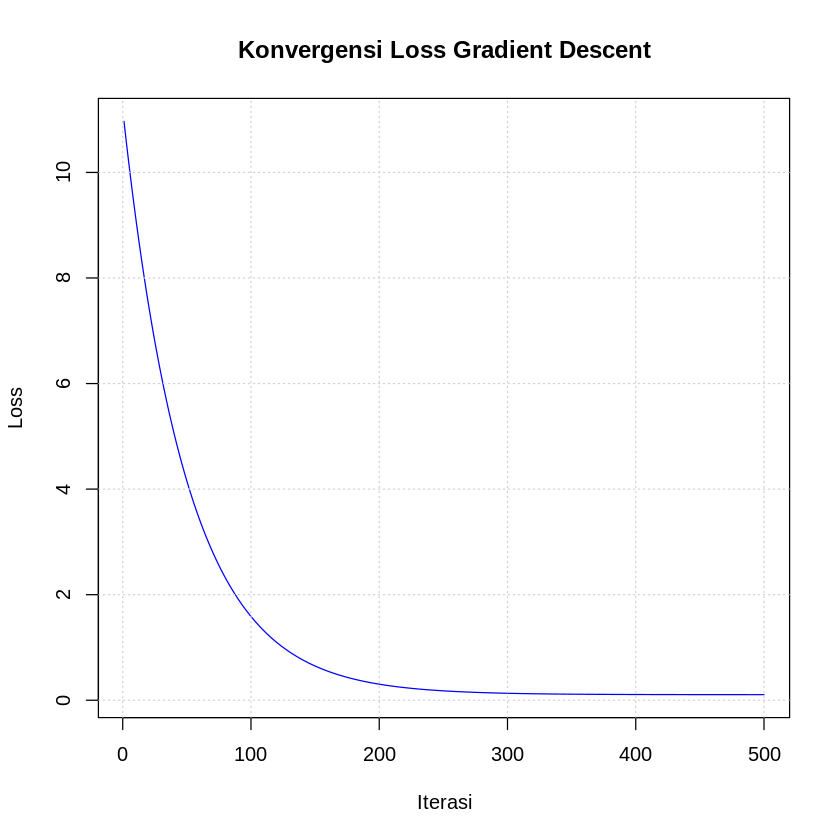

In [7]:
plot(result$loss, type = "l", col = "blue",
     xlab = "Iterasi", ylab = "Loss",
     main = "Konvergensi Loss Gradient Descent")
grid()

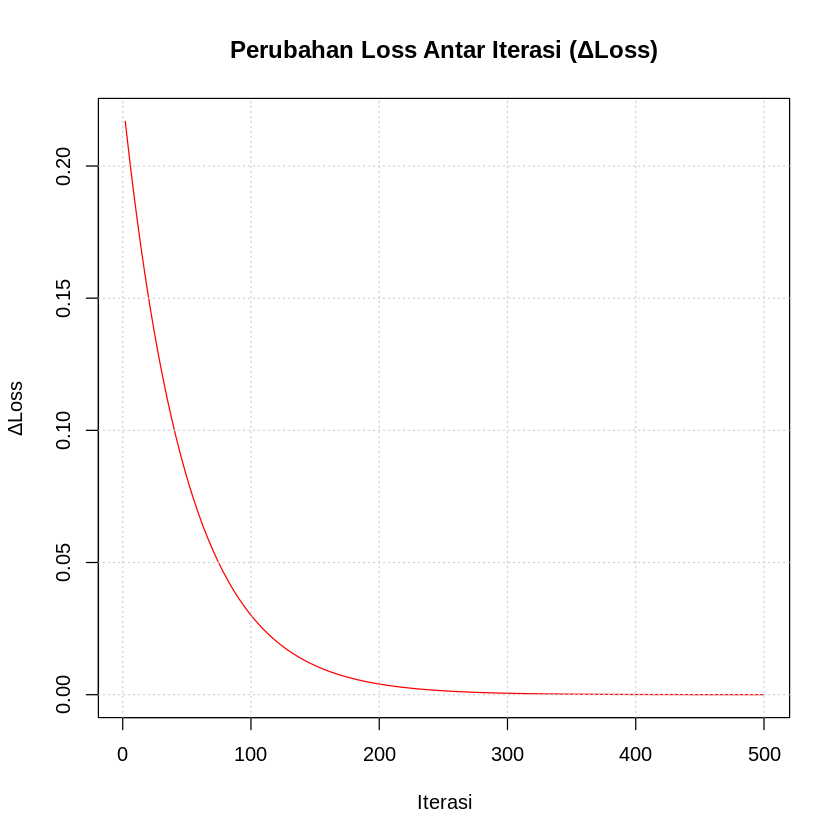

In [8]:
plot(result$delta_loss, type = "l", col = "red",
     xlab = "Iterasi", ylab = "ΔLoss",
     main = "Perubahan Loss Antar Iterasi (ΔLoss)")
grid()

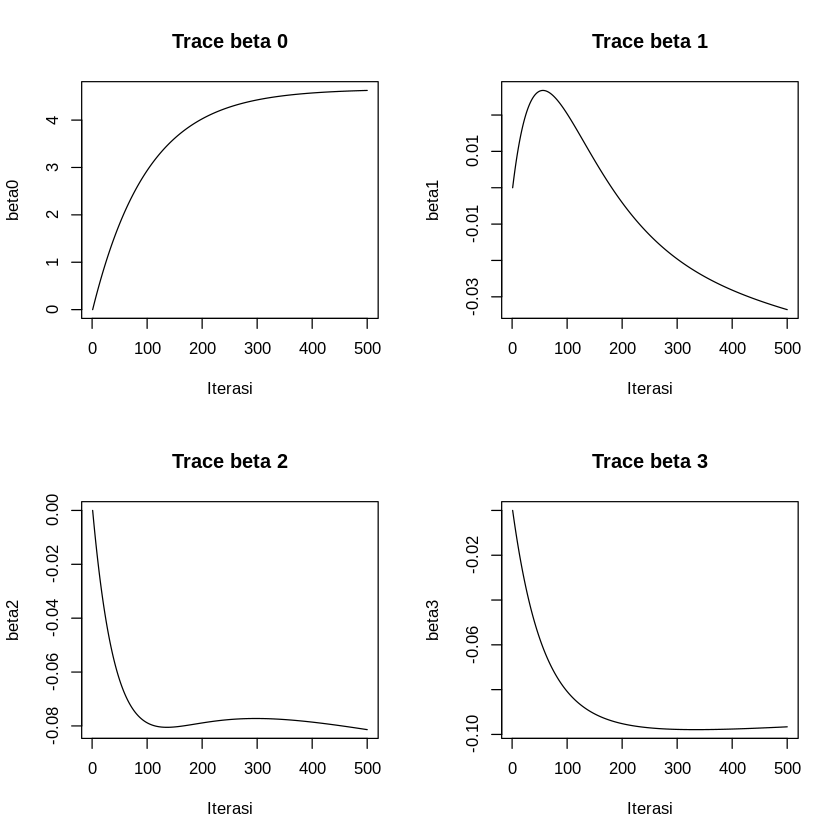

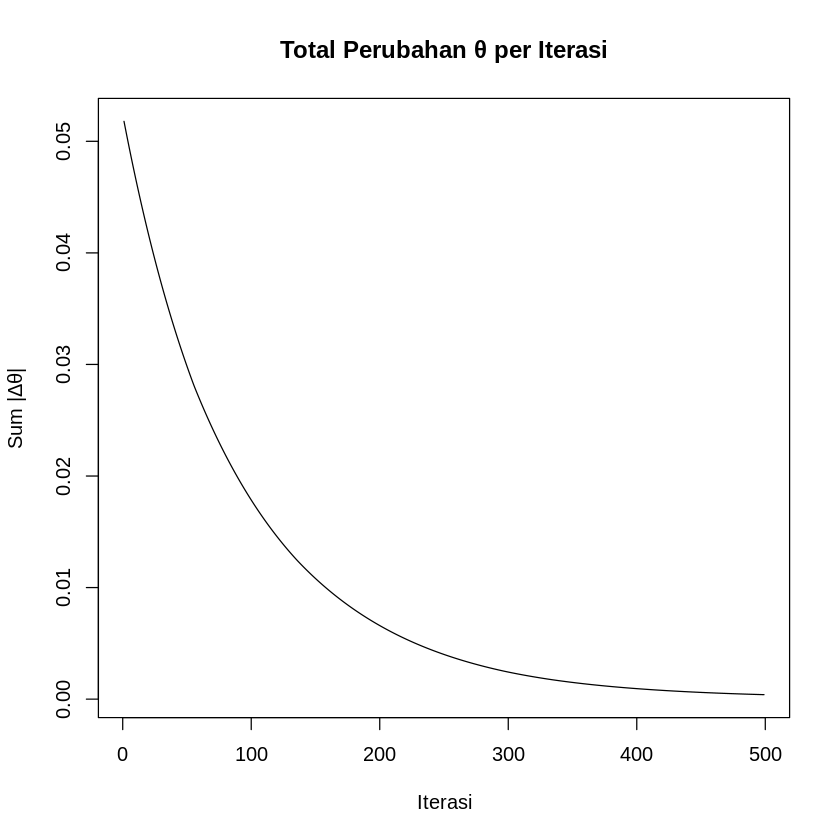

In [11]:
model <- gradient_descent_tracking(X_train, y_train, lr = 0.01, it = 500, tol = 1e-8)

# trace plot untuk tiap beta
beta_mat <- do.call(cbind, lapply(model$beta_history, c))
beta_mat <- t(beta_mat) # iterasi sebagai baris, parameter sebagai kolom
par(mfrow = c(2,2))
for (j in 1:ncol(beta_mat)) {
  plot(beta_mat[, j], type = "l", xlab = "Iterasi", ylab = paste0("beta", j-1),
       main = paste("Trace beta", j-1))
}

# delta beta (magnitudo perubahan) per iterasi
delta_beta <- apply(abs(diff(beta_mat)), 2, function(x) x)
par(mfrow = c(1,1))
plot(rowSums(abs(diff(beta_mat))), type = "l", xlab = "Iterasi", ylab = "Sum |Δθ|",
     main = "Total Perubahan θ per Iterasi")

In [12]:
library(dplyr)

# Membuat dataframe dari hasil GD
beta_df <- do.call(rbind, lapply(result$beta_history, function(x) t(x)))
colnames(beta_df) <- paste0("beta_", 1:ncol(beta_df))

iteration <- 1:nrow(beta_df)

output_table <- data.frame(
  Iterasi = iteration,
  beta_df,
  Delta_beta = result$delta_beta[1:nrow(beta_df)],
  Loss = result$loss[1:nrow(beta_df)],
  Delta_Loss = result$delta_loss[1:nrow(beta_df)]
)

head(output_table)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




,Iterasi,beta_1,beta_2,beta_3,beta_4,Delta_beta,Loss,Delta_Loss
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,0.00000000,0.000000000,0.000000000,0.000000000,0.04669081,10.96764,Inf
2,2,0.04658904,0.001237472,-0.002206834,-0.001758311,0.04622016,10.75073,0.2169044
3,3,0.09271121,0.002433930,-0.004360851,-0.003483851,0.04575433,10.53818,0.2125537
4,4,0.13837119,0.003590344,-0.006463199,-0.005177252,0.04529329,10.32989,0.2082911
5,5,0.18357365,0.004707663,-0.008515006,-0.006839134,0.04483696,10.12577,0.2041147
6,6,0.22832316,0.005786813,-0.010517372,-0.008470107,0.04438532,9.92575,0.2000228


In [13]:
tail(output_table)

,Iterasi,beta_1,beta_2,beta_3,beta_4,Delta_beta,Loss,Delta_Loss
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
495,495,4.623891,-0.03330143,-0.08121649,-0.09665451,0.0003305456,0.1056603,1.108792e-05
496,496,4.624216,-0.03334701,-0.08124758,-0.09664292,0.0003273246,0.1056494,1.087280e-05
497,497,4.624539,-0.03339245,-0.08127871,-0.09663131,0.0003241365,0.1056388,1.066196e-05
498,498,4.624858,-0.03343776,-0.08130989,-0.09661968,0.0003209808,0.1056283,1.045530e-05
499,499,4.625174,-0.03348294,-0.08134111,-0.09660802,0.0003178574,0.1056180,1.025274e-05
500,500,4.625487,-0.03352799,-0.08137237,-0.09659634,0.0003147660,0.1056080,1.005420e-05


In [15]:
###############################################
# 7. EVALUASI MODEL (TESTING)
###############################################

y_pred_test <- X_test %*% model$beta

MSE <- mean((y_pred_test - y_test)^2)
RMSE <- sqrt(MSE)
MAE <- mean(abs(y_pred_test - y_test))

# R-squared
SS_res <- sum((y_test - y_pred_test)^2)
SS_tot <- sum((y_test - mean(y_test))^2)
R2 <- 1 - (SS_res / SS_tot)

list(
  MSE = MSE,
  RMSE = RMSE,
  MAE = MAE,
  R2 = R2
)

$MSE
[1] 0.2108786

$RMSE
[1] 0.4592152

$MAE
[1] 0.3620193

$R2
[1] -0.03644083